In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!gdown https://drive.google.com/file/d/1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx/view?usp=sharing --fuzzy -O data.csv

Downloading...
From: https://drive.google.com/uc?id=1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx
To: /content/data.csv
100% 8.07M/8.07M [00:00<00:00, 43.9MB/s]


In [3]:
class Config:
    vocab_size = 15000 # Vocabulary Size
    sequence_length = 20
    batch_size = 64
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 2
    epochs = 10 # Number of Epochs to train
    model_path = "model.h5"
    begin_token = "[start]"
    end_token = "[end]"
    use_pretrained_model = False # Download pretrained Model to speedup the training
config = Config()

In [4]:
data = pd.read_csv("data.csv")
data.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [5]:
data["spanish"] = data["spanish"].apply(lambda item: config.begin_token + " " + item + " " + config.end_token)

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")


In [7]:

english_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)

In [8]:
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

In [9]:
def preprocess(english, spanish):
    return (english, spanish[:, :-1]), spanish[:, 1:]

In [10]:
def make_dataset(df, batch_size, mode):
    english = english_vectorization(list(df["english"]))
    spanish = spanish_vectorization(list(df["spanish"]))
    dataset = tf.data.Dataset.from_tensor_slices((english, spanish))
    if mode == "train":
       dataset = dataset.shuffle(256)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.take(len(df) // batch_size).cache().prefetch(16).repeat(1)
    return dataset

In [11]:
train, valid = train_test_split(data, test_size=config.validation_split)
train.shape, valid.shape

train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [12]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        inp_complex = tf.cast(inputs, tf.complex64)
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


In [14]:
class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)

        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [15]:
def get_fnet(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_outputs = FNetEncoder(config.embed_dim, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = FNetDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs")

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="fnet"
    )
    return fnet

In [16]:
fnet = get_fnet(config)
fnet.summary()

Model: "fnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                             

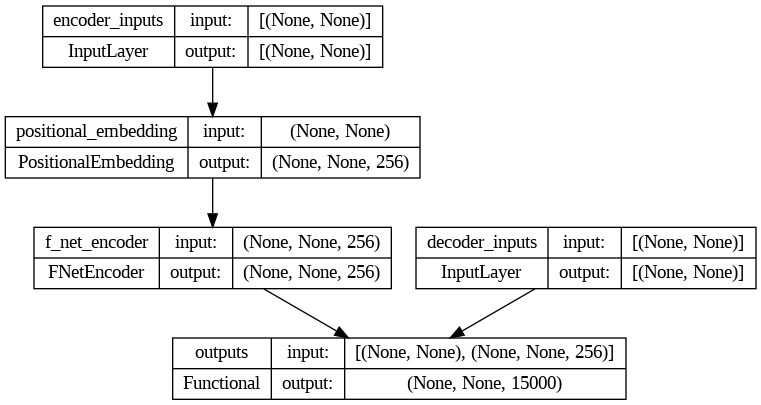

In [17]:
keras.utils.plot_model(fnet, show_shapes=True)

In [18]:
fnet.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [19]:
checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, save_weights_only=True, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-4)


In [20]:
if config.use_pretrained_model:
    model_path = keras.utils.get_file(config.model_path, "https://github.com/LoniQin/English-Spanish-Transaltion-FNet/raw/main/" + config.model_path)
    fnet.load_weights(model_path)
    history = fnet.fit(train_ds.take(100), epochs=1, validation_data=valid_ds.take(10), callbacks=[checkpoint, reduce_lr])
else:
    history = fnet.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, reduce_lr])



Epoch 1/10


1579/1579 [==============================] - 111s 59ms/step - loss: 3.6413 - accuracy: 0.4340 - val_loss: 2.5972 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/10
1579/1579 [==============================] - 76s 48ms/step - loss: 2.3953 - accuracy: 0.5713 - val_loss: 2.0733 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 3/10
1579/1579 [==============================] - 72s 45ms/step - loss: 1.8812 - accuracy: 0.6333 - val_loss: 1.8839 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 4/10
1579/1579 [==============================] - 72s 45ms/step - loss: 1.5846 - accuracy: 0.6715 - val_loss: 1.7983 - val_accuracy: 0.6581 - lr: 0.0010
Epoch 5/10
1579/1579 [==============================] - 71s 45ms/step - loss: 1.3878 - accuracy: 0.6993 - val_loss: 1.7749 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 6/10
1579/1579 [==============================] - 71s 45ms/step - loss: 1.2450 - accuracy: 0.7219 - val_loss: 1.7572 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 7/10
1579/1579 [==============================] - 

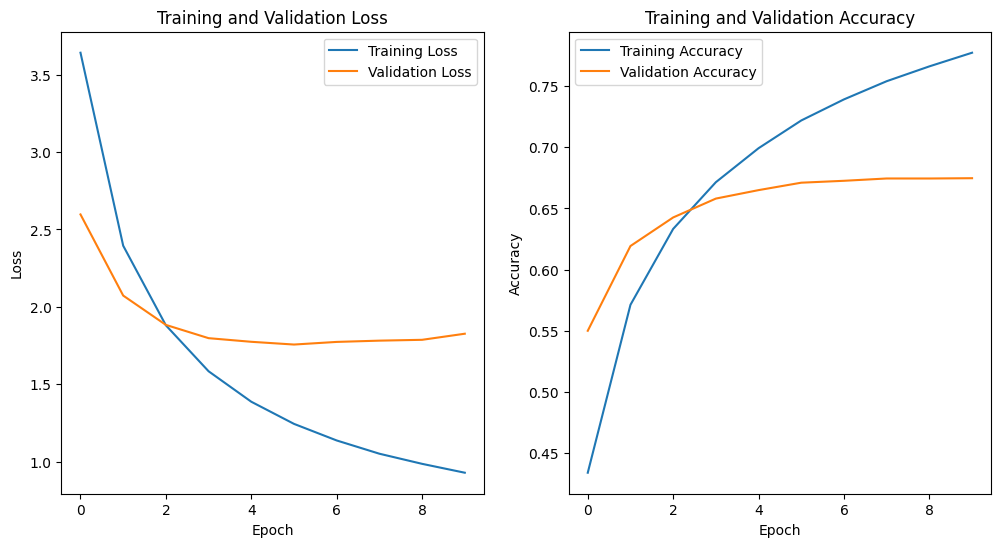

In [21]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [22]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))

In [23]:
def decode_sequence(fnet, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = config.begin_token
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = fnet([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == config.end_token:
            break
    return decoded_sentence


In [25]:
fnet.load_weights(config.model_path)

In [26]:
for i in np.random.choice(len(data), 10):
    item = data.iloc[i]
    translated = decode_sequence(fnet, item["english"])
    print("English:", item["english"])
    print("Spanish:", item["spanish"])
    print("Translated:", translated)

English: I have to wake Tom up.
Spanish: [start] Tengo que despertar a Tom. [end]
Translated: [start] tengo que despertar a tom [end]
English: I'm not drunk.
Spanish: [start] No estoy ebrio. [end]
Translated: [start] no estoy borracho [end]
English: I'm glad you like it.
Spanish: [start] Me alegra que te guste. [end]
Translated: [start] me gusta que te estoy contento [end]
English: Come on in.
Spanish: [start] Pase. [end]
Translated: [start] entra [end]
English: Life is difficult.
Spanish: [start] La vida es dura. [end]
Translated: [start] la vida es difícil [end]
English: Nothing is the matter with the car. It's just that you are a bad driver.
Spanish: [start] No hay ningún problema con el coche. Es simplemente que eres un mal conductor. [end]
Translated: [start] no es el asunto más malo que es malo para el único que no es malo [end]
English: The sun sets earlier in the winter.
Spanish: [start] El sol se oculta más temprano en invierno. [end]
Translated: [start] el sol se levanta más 